# Planar data classification
The present tutorial focuses on the creation of a proper Neural Network with one hidden layer. You can go back to the previous tutorial to check the difference in performance between these two models.

## Preparing the workspace

Let's start by importing our usual libraries

In [ ]:
import matplotlib.pyplot as plt
import sklearn.linear_model
import numpy as np
import sys
import os

In [128]:
cwd = os.getcwd()
helper_path = os.path.join(cwd,'..','..')

sys.path.append(helper_path)

import helper_functions as hf

## Fetching the data
We are going to be using a synthetic dataset. The dataset is based on the following parametric equation:

$$\begin{gathered}
x = a \cos(bt) \cos(t)\\
y = a \cos(bt) \sin(t)
\end{gathered}
$$

Visualising the above equation creates a 2D rose with multiple petals. Our `helper_functions` module has a method to create this dataset. Let's create our synthetic dataset.

In [129]:
X, Y = hf.flower_dataset()

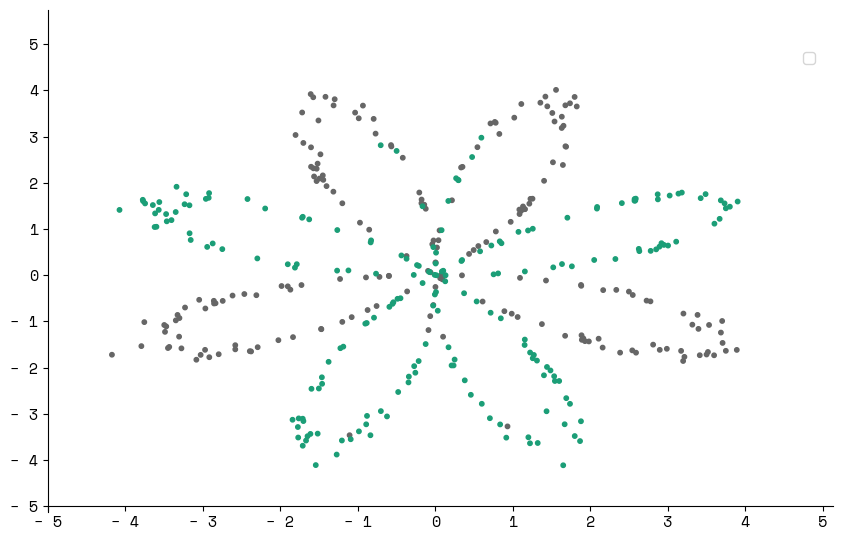

In [130]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(X[0,:],X[1,:], c=Y,s=10,cmap=plt.cm.Dark2_r,)
hf.make_fig_pretty(ax)

In [131]:
print('X CONTAINS {} INSTANCES, EACH WITH {} FEATURES'.format(X.shape[1],X.shape[0]))
print('Y CONTAINS {} INSTANCES, EACH WITH {} FEATURE'.format(Y.shape[1],Y.shape[0]))

X CONTAINS 400 INSTANCES, EACH WITH 2 FEATURES
Y CONTAINS 400 INSTANCES, EACH WITH 1 FEATURE


As we can observe, the method creates the rose using 2 features and a single feature label. In this case, our dataset contains 400 instances.

> The `flower_dataset()` method adds a small level of noise by default. You can play around with this value to create a more challenging dataset.

Our goal is to create a Neural Network that will allows to classify the data points as one of the two classes present (the different petal colours represent these classes).

## Pre-processing and simple regressor
We are going to compare our Neural Network to a standard logistic regressor. For this task we will use the tools provided by 'scikit-learn'. To evaluate the model we will use K-fold cross validation.

In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

cv = StratifiedKFold(n_splits=3,
                     shuffle=True,
                     random_state=101)

clf_log = LogisticRegression()
y_preds = cross_val_predict(clf_log,
                            X.T,
                            Y.reshape((-1)),
                            cv=cv)

print(classification_report(Y.ravel(), y_preds))

              precision    recall  f1-score   support

           0       0.48      0.48      0.48       200
           1       0.48      0.48      0.48       200

    accuracy                           0.48       400
   macro avg       0.48      0.48      0.48       400
weighted avg       0.48      0.48      0.48       400



Our standard logistic regressor has the accuracy of a coin toss (approximately 48%), and we observe the same effect for both precision and recall. We can visualise the process by which the model determines the class of each data point through its decision boundaries. 

> Plotting the decision boundary involves creating a grid and using contours. This is further explained in [02_CLASSIFICATION_PROBLEMS\S01](00_INTRODUCTION\02_CLASSIFICATION_PROBLEMS\S01_decision_boundary.md)

In [133]:
def plot_decision_boundary(model, X, y):
    # Set min and max values
    x_min, x_max = X[0, :].min()-1,  X[0, :].max()+1
    y_min, y_max = X[1, :].min()-1,  X[1, :].max()+1

    # Create uniform sample across each dimension
    res = 0.01  # resolution
    x_grid = np.arange(x_min, x_max, res)
    y_grid = np.arange(y_min, y_max, res)

    # Generate a grid from the above vectors
    xx, yy = np.meshgrid(x_grid, y_grid)

    # Predict the function value for the whole grid
    y_hat = model(np.c_[xx.ravel(), yy.ravel()])
    Z = y_hat.reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired_r)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Paired_r, edgecolors='k')


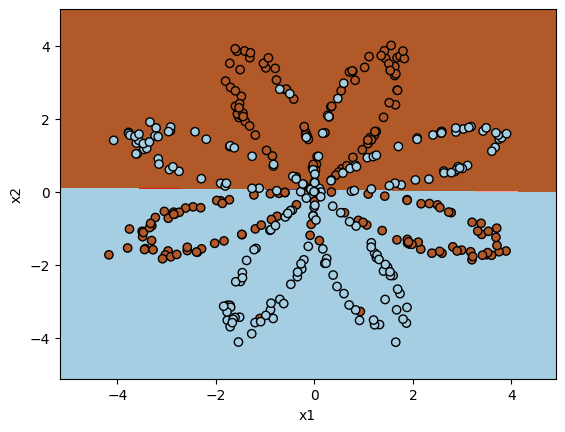

In [134]:
clf_log.fit(X.T,Y.flatten())
plot_decision_boundary(lambda x: clf_log.predict(x), X, Y)

The logistic regression model underperforms on this dataset because it is not linearly separable. A neural network could potentially show better results as it is not constrained by the linearity of the dataset. 

The standard way to build a Neural Network is as follows:
1. Define the network structure, including the number of inputs and hidden units.
1. Initialize the model's parameters.
1. Implement forward propagation.
1. Implement backward propagation.
1. Loop:
   1. Run forward propagation
   2. Compute loss
   3. Get gradients (backward propagation)
   4. Update model's parameters (gradient descent)

We are going to create a single layer neural network like this one:

![](https://gitlab.cs.man.ac.uk/mbgnrdc2/intro_to_machine_learning/raw/master/00_INTRODUCTION/figures/T02_nn.png?inline=false)

Here the superscript brackets \[ \] indicate the computations corresponding to a specific layer. For instance \[1\], refers to the computations of our first hidden layer. With this in mind we can mathematically describe the computation flow for one training example $x^{(i)}$. For layer one:

$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})$$

then, we use the output of layer one as the input for layer two:

$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})$$

Finally, we can use the output probability to decide if the training example belongs to the positive class.

$$\begin{gathered}
y^{(i)}_{prediction} = \begin{cases} 1 & \text{if } a^{[2](i)} > 0.5 \\ 0 & \text{otherwise } \end{cases}
\end{gathered}
$$

Here we are using a 0.5 threshold, but one can choose this threshold to tweak the precision and recall of the model.
Once all data instances have been processed, we can also compute the cost function $J$ as follows: 

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small $$

Let's implement this computationally. 

First we are going to define a method to compute the sizes of our input,hidden, and output layer.

In [135]:
def layer_size(X: np.array, Y: np.array, n_hidden_units: int = 4):
    """
    Compute layer size based on the size of the input, and output data
    This method should be used along the methods to build our
    neural network

    Args:
        X (np.array): Feature/s array
        Y (np.array): Target label/s array
        n_hidden_units (int, optional): _description_. Defaults to 4.
    """
    n_x = X.shape[0]
    n_h = n_hidden_units
    n_y = Y.shape[0]
    return(n_x, n_h, n_y)

Let's test that the above method works as intended

In [136]:
np.random.seed(1)
X_assess = np.random.randn(5, 3)
Y_assess = np.random.randn(2, 3)

(n_x, n_h, n_y) = layer_size(X_assess, Y_assess)

try:
    assert n_x == 5
    print("n_x = " + str(n_x))
    assert n_h == 4
    print("n_h = " + str(n_h))
    assert n_y == 2
    print("n_y = " + str(n_y))
except AssertionError:
    hf.trace_reporter()    

n_x = 5
n_h = 4
n_y = 2


Next we need to initialise our weights and bias parameters. For this particular network we'll use a random initialization from a standard normal distribution with variance from `0` to `1` with a `0.01` scaling factor. Our bias parameters will be set to zero.

The following initialisation must create parameter vectors with the shape of our desired neural network architecture. Thus, we are going to create a method that takes the output of our previous function as inputs to determined the appropriate shape of our vectors.

> In theory, the initialisation of parameters should always be random when training from scratch. However, to allow us to show reproducible results we are going to set a specific random seed that will make the initialisation produce the same results on different runs (or when running on a different machine).
> Initialising all weights to zero or initialising them to the same value will disable the neural network, as this would make all hidden units completely symmetric (identical).

In [137]:
def initialise_parameters(n_x: int, n_h: int, n_y: int, seed: int = 101) -> dict:
    """
    Neural network weights and bias initialiser method

    Args:
        n_x (int): size of input layer
        n_h (int): size of hidden layer
        n_y (int): size of output layer
        seed (int, optional): Random seed setting (to enable reproducibility). Defaults to 101.

    Returns:
        dict: parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)    """
    np.random.seed(seed)

    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    try:
        assert (W1.shape == (n_h, n_x))
        assert (b1.shape == (n_h, 1))
        assert (W2.shape == (n_y, n_h))
        assert (b2.shape == (n_y, 1))
    except AssertionError:
        hf.trace_reporter()

    params = {'W1': W1,
              'b1': b1,
              'W2': W2,
              'b2': b2}
    return params


Let's test the above method and see what kind of vectorised parameters it produces.

In [138]:
n_x, n_h, n_y = layer_size(X,Y)
parameters = initialise_parameters(n_x, n_h, n_y)

for key,val in parameters.items():
    print(f'The vector {key} has the following shape {val.shape}')
    print(f'\n{val}\n')

The vector W1 has the following shape (4, 2)

[[ 0.0270685   0.00628133]
 [ 0.00907969  0.00503826]
 [ 0.00651118 -0.00319318]
 [-0.00848077  0.00605965]]

The vector b1 has the following shape (4, 1)

[[0.]
 [0.]
 [0.]
 [0.]]

The vector W2 has the following shape (1, 4)

[[-0.02018168  0.00740122  0.00528813 -0.00589001]]

The vector b2 has the following shape (1, 1)

[[0.]]



## Forward propagation
The next step for our Neural Network is to be able to compute the forward pass. This means passing each of our data instances through the network and computing 

$$
\mathbf{Z}^{[1]}, \mathbf{A}^{[1]}, \mathbf{Z}^{[2]} \quad \text{and} \quad \mathbf{A}^{[2]}
$$

For the implementation, we are going to store all of the above computations on a dictionary that we will be using for the backward pass.

> The mathematical computations to be performed have been described near the beginning of this notebook.

In [139]:
class AttributeDict(dict):
    """
    Dictionary to Object helper. It turns a dictionary into a class object
    that uses the original dictionary keys as parameters that can be 
    accessed and modified using the dot (.) operand.

    Args:
        dict (dict): Dictionary to be transformed
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


def forward_pass(X:np.array, parameters:dict) -> tuple:
    """
    Compute forward propagation on a single layer Neural Network


    Args:
        X (np:array):
            Training dataset expressed as an array where rows are data instances
        parameters (dict): Previously initialised parameters

    Returns:
        tuple (np.array, dict): (A2, all_calculations) 
    """
    p = AttributeDict(parameters)

    Z1 = np.dot(p.W1, X) + p.b1
    A1 = np.tanh(Z1)

    Z2 = np.dot(p.W2, A1) + p.b2
    A2 = hf.sigmoid(Z2)

    # Assert that we process the correct number of instances
    try:
        assert (A2.shape == (1, X.shape[1]))
    except AssertionError:
        hf.trace_reporter()

    aux_cache = {"Z1": Z1,
                 "A1": A1,
                 "Z2": Z2,
                 "A2": A2}

    return A2, aux_cache

Now we can use our `forward_pass` method to process all of our data instances. Although, internally the method is checking for the correct shape of the last layer based on the number of instances, let's corroborate this by testing the method.

In [140]:
A2, cache = forward_pass(X, parameters)
A2.shape

(1, 400)

We can observe that we have an array that contains the computation of the forward propagation for our `400` data instances. 

The next step is to compute the loss using the cost function $J$ presented earlier. 

In [141]:
def compute_loss(A2: np.array, Y: np.array) -> float:
    """
    Compute the cost function using the definition
    of cross-entropy loss
    
    J = 1/m Sum(y * log (A2) + (1- y) log (1-A2) )

    Args:
        A2 (np.array): Output of the last layer of the neural network
        Y (np.array): Expected output (labels corresponding to the training dataset)

    Returns:
        float: average cross-entropy loss for all data instances
    """
    m = Y.shape[1]  # number of instances

    # Cross entropy loss J = 1/m Sum(y * log (A2) + (1- y) log (1-A2) )
    
    # Abstraction:
    # J = 1/m Sum (P1 + P2)
    P1 = np.multiply(Y, np.log(A2))
    P2 = np.multiply((1-Y), np.log(1-A2))
    loss = -1/m * np.sum(P1+P2)

    # Make sure we obtain a single number instead of an array
    # containing a single number
    loss = np.squeeze(loss)

    try:
        assert(isinstance(loss, float))
    except AssertionError:
        hf.trace_reporter()

    return loss

In [142]:
loss_cost = compute_loss(A2, Y)

print('Computed loss: {:2.3f}'.format(loss_cost))

Computed loss: 0.693


> Here the terms cost and loss are used interchangeably. However, in ML literature you'll often find that cost is used to refer to the averaged loss of the entire dataset, while the term loss is used to refer to single data instances.

Until this point we have implemented half the steps required for our neural network to work. After passing all of our data instances through the network, we need to compute the backward pass (i.e. compute the gradients of each layer with the help of the chain rule).

In this tutorial we won't go in depth on how to mathematically obtain the derivatives (this is one of the reasons this step is one of the most challenging when building neural networks), rather, we will implement the following formulas:

$$
\begin{gathered}
\delta Z^{[2]} = A^{[2]} - Y \\
\delta W^{[2]} = \delta Z^{[2]} \cdot A^{[1]^T}  \\
\delta b^{[2]} = \dfrac{1}{m} \sum \delta Z^{[2]}\\
\delta Z^{[1]} = (W^{[2]^T} \cdot \delta Z^{[2]}) * \delta g^{[1]} (Z^{[1]}) \\
\delta W^{[1]} = \dfrac{\delta Z^{[1]} \cdot A^{[0]^T}}{m}   \\
\delta b^{[1]} = \dfrac{1}{m} \sum \delta Z^{[1]}\\
\end{gathered}
$$

here $g^{[1]}(z)$ represents the activation function (in this case $tanh$). Thus,

$$
g^{[1]'}(z) = 1-(g^{[1]}(z))^2
$$

We are going to implement the above equations in a single function.

In [143]:
def backward_pass(parameters: dict, cache: dict, X: np.array, Y: np.array) -> dict:
    """
    Compute backward propagation for a single layer neural network

    Args:
        parameters (dict): Previously initialised parameters 
        cache (dict): Cached computations from the forward pass
        X (np.array): 
            Training dataset expressed as an array where rows are data instances
        Y (np.array): 
            Target labels for the training dataset

    Returns:
        dict: computed gradients from the backward pass
    """
    m = X.shape[1]  # number of instances
    p = AttributeDict(parameters)
    c = AttributeDict(cache)

    # Backward propagation: calculate dW1, db1, dW2, db2.
    dZ2 = c.A2 - Y
    dW2 = (1/m) * np.dot(dZ2, c.A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(p.W2.T, dZ2) * (1 - np.power(c.A1, 2))
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {"dW1": dW1,
                 "db1": db1,
                 "dW2": dW2,
                 "db2": db2}

    return gradients


In [144]:
gradients = backward_pass(parameters, cache, X, Y)

for key,val in gradients.items():
    print(f'The vector {key} has the following shape {val.shape}')
    print(f'\n{val}\n')

The vector dW1 has the following shape (4, 2)

[[-1.18842881e-04 -4.44248563e-03]
 [ 4.21759270e-05  1.62418349e-03]
 [ 2.93293982e-05  1.16067819e-03]
 [-3.21622387e-05 -1.29250398e-03]]

The vector db1 has the following shape (4, 1)

[[ 7.37326518e-07]
 [-3.63719908e-08]
 [-1.94747519e-08]
 [ 4.16599462e-08]]

The vector dW2 has the following shape (1, 4)

[[ 0.00153423  0.00115687 -0.00066444  0.00128269]]

The vector db2 has the following shape (1, 1)

[[-5.56242235e-07]]



The next step is to make the neural network learn. This means updating the parameters of our network using the gradients computed. The weight of the update (the learning rate) the size of the step that we are going towards the expected minimum loss.

Mathematically, the update rule is described:

$$
\mathbf{\theta} = \mathbf{\theta} - \alpha \dfrac{\delta J }{ \delta \mathbf{\theta} }
$$

here $\alpha$ represents the learning rate, and $\mathbf{\theta}$ is the parameters vector. Let's implement this computationally.

In [145]:
def update_params(parameters:dict, gradients:dict, learning_rate:float=1.0) -> dict:
    """
    Update parameters of a single layer neural network

    Args:
        parameters (dict): Previously initialised parameters 
        gradients (dict): Backward propagation gradients
        learning_rate (float, optional): Size of the update step. Defaults to 1.0.

    Returns:
        dict: updated parameters
    """
    p = AttributeDict(parameters)
    g = AttributeDict(gradients)

    W1 = p.W1 - learning_rate * g.dW1
    b1 = p.b1 - learning_rate * g.db1
    W2 = p.W2 - learning_rate * g.dW2
    b2 = p.b2 - learning_rate * g.db2

    updated_parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return updated_parameters

In [146]:
updated_parameters = update_params(parameters, gradients)

for key,val in updated_parameters.items():
    print(f'The vector {key} has the following shape {val.shape}')
    print(f'\n{val}\n')

The vector W1 has the following shape (4, 2)

[[ 0.02718734  0.01072381]
 [ 0.00903752  0.00341407]
 [ 0.00648185 -0.00435386]
 [-0.00844861  0.00735216]]

The vector b1 has the following shape (4, 1)

[[-7.37326518e-07]
 [ 3.63719908e-08]
 [ 1.94747519e-08]
 [-4.16599462e-08]]

The vector W2 has the following shape (1, 4)

[[-0.02171591  0.00624435  0.00595257 -0.0071727 ]]

The vector b2 has the following shape (1, 1)

[[5.56242235e-07]]



The results show that we are simply scaling the initialised parameters as they remain the same shape.

Now we can fully implement our single layer neural network. We can combine all of the above developed elements into a single function, that will loop through a certain amount of iterations. In this loop, forward propagation, backward propagation, and parameters update are going to be computed at each iteration. The performance metric in this case will be the loss.

In [147]:
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm

def neural_network(X: np.array, Y: np.array,
                   n_hidden_units: int,
                   n_iterations: int = 100,
                   random_seed: int = 101,
                   print_loss: bool = False) -> dict:
    """
    Single layer neural network

    Args:
        X (np.array): 
            Training dataset expressed as an array where rows are data instances
        Y (np.array): 
            Target labels for the training dataset
        n_hidden_units (int): 
            Number of hidden units for the single layer.
        n_iterations (int, optional):
            Number of learning iterations. Defaults to 100.
        random_seed (int, optional):
            Initialisation seed. Defaults to 101.
        print_loss (bool, optional):
            Flag to enable verbose. Defaults to False.

    Returns:
        dict: neural network parameters
    """

    np.random.seed(random_seed)
    n_x = layer_size(X, Y)[0]
    n_y = layer_size(X, Y)[2]

    parameters = initialise_parameters(n_x,
                                       n_hidden_units,
                                       n_y,
                                       random_seed)

    for ix in tqdm_notebook(range(0, n_iterations), desc='TRAINING'):
        A2, cache = forward_pass(X, parameters)

        loss = compute_loss(A2, Y)

        gradients = backward_pass(parameters, cache, X, Y)

        parameters = update_params(parameters, gradients)

        if print_loss and ix % 1000 == 0:
            tqdm_notebook.write(f"ITERATION {ix}:\n > LOSS:{loss}")
    
    return parameters


In [167]:
parameters = neural_network(X, Y,
                            n_hidden_units=4,
                            n_iterations=10000,
                            print_loss=True)

TRAINING:   0%|          | 0/10000 [00:00<?, ?it/s]

ITERATION 0:
 > LOSS:0.6931136243140341
ITERATION 1000:
 > LOSS:0.22436494271193663
ITERATION 2000:
 > LOSS:0.214189985647123
ITERATION 3000:
 > LOSS:0.20965415595096326
ITERATION 4000:
 > LOSS:0.20672072442528952
ITERATION 5000:
 > LOSS:0.2028134163087637
ITERATION 6000:
 > LOSS:0.1997675130191502
ITERATION 7000:
 > LOSS:0.19767020366307914
ITERATION 8000:
 > LOSS:0.19595454390353426
ITERATION 9000:
 > LOSS:0.1945431169331632


Our model has learned the patterns of the data and can now be used to make predictions. The goal with the flower dataset is to be able to categorize each data point as a class of petal no matter its location. 

To make predictions we need to pass the data instances that we want to classify through our updated network. This means that we are going to be using forward propagation to obtain the predictions.

Mathematically, we are going to set a threshold (in this case 0.5) to determine the final class:

$$\begin{gathered}
y^{(i)}_{prediction} = \begin{cases} 1 & \text{if } a^{[2](i)} > 0.5 \\ 0 & \text{otherwise } \end{cases}
\end{gathered}
$$

Let's implement the above equation

In [168]:
def predict(parameters: dict, X: np.array, threshold:float=0.5) -> np.array:
    """
    Predict the target class of a set of data points

    Args:
        parameters (dict): Updated parameters from a single layer neural network
        X (np.array): data to use for predictions

    Returns:
        np.array: predictions
    """
    A2, _ = forward_pass(X, parameters)
    predictions = A2 > threshold

    return predictions


In [169]:
predictions = predict(parameters, X, 0.5)
predictions.shape

(1, 400)

The result of our prediction method is an array containing the individual predictions for each data instance.

Using this array we can evaluate the performance of our model as with any other classification algorithms. Evaluating the model will consist of computing its classification performance metrics. But first, let's visualise the decision boundary of this neural network.

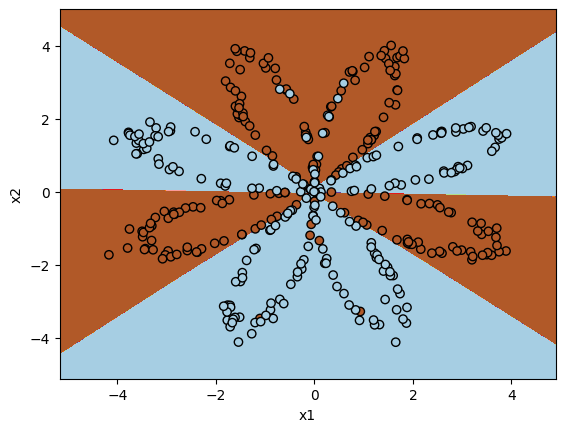

In [171]:
# Since the decision boundary visualisation method requires
# combines predictions and actual values, we must create
# a prediction method that uses X^T
preditc_func = lambda x: predict(parameters, x.T,0.3)

plot_decision_boundary(preditc_func, X, Y)

The neural network decision boundary is more complex than that of the first logistic model. This visualisation shows how our neural network will determine the class of new data points. While some data points might be misclassified, overall we can say that it does a good job at identifying the underlying patterns of our dataset.

The next step is to give a number to the actual classification power of the model.

In [152]:
# Compute TP and TF to obtain accuracy
true_positives = np.sum(np.logical_and(Y, predictions))
true_negatives = np.sum(np.logical_and(
    np.logical_not(Y),
    np.logical_not(predictions)
))

acc = (true_positives + true_negatives) / Y.size
print('Accuracy of the model -> {:2.2%}'.format(acc))

Accuracy of the model -> 92.75%


The neural network presents a significant improvement in accuracy when compared to the simple logistic regression model. 

What about it's performance as a binary classifier?

In [154]:
print(classification_report(Y.ravel(), predictions.ravel()))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       200
           1       0.94      0.92      0.93       200

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



As we can observe in these results, neural networks are capable of learning non-linear complex patterns, unlike traditional machine learning algorithms. Our trained neural network exhibits a high accuracy, and a balance precision and recall.

## Tuning neural networks
The typical workflow when solving machine learning problems through deep learning is to first find a good neural network architecture that provides us with a sensible solution. The next step is to fine-tune the hyperparameters of the network to maximise its learning potential. 

The range of hyperparameters in the network will depend on the problem, and the architecture being used. Hyperparameters can encompass activation functions, learning rate, regularization schemes, number of layers, number of hidden units, and so on.

In this example, we are going to explore how the number of hidden units affects the performance of the model through the visualisation of their decision boundaries.

TRAINING:   0%|          | 0/5000 [00:00<?, ?it/s]

Accuracy for 2 hidden units -> 66.50%


TRAINING:   0%|          | 0/5000 [00:00<?, ?it/s]

Accuracy for 4 hidden units -> 92.75%


TRAINING:   0%|          | 0/5000 [00:00<?, ?it/s]

Accuracy for 6 hidden units -> 92.75%


TRAINING:   0%|          | 0/5000 [00:00<?, ?it/s]

Accuracy for 8 hidden units -> 93.00%


TRAINING:   0%|          | 0/5000 [00:00<?, ?it/s]

Accuracy for 10 hidden units -> 93.75%


TRAINING:   0%|          | 0/5000 [00:00<?, ?it/s]

Accuracy for 20 hidden units -> 94.00%


TRAINING:   0%|          | 0/5000 [00:00<?, ?it/s]

Accuracy for 30 hidden units -> 93.50%


TRAINING:   0%|          | 0/5000 [00:00<?, ?it/s]

Accuracy for 40 hidden units -> 94.00%


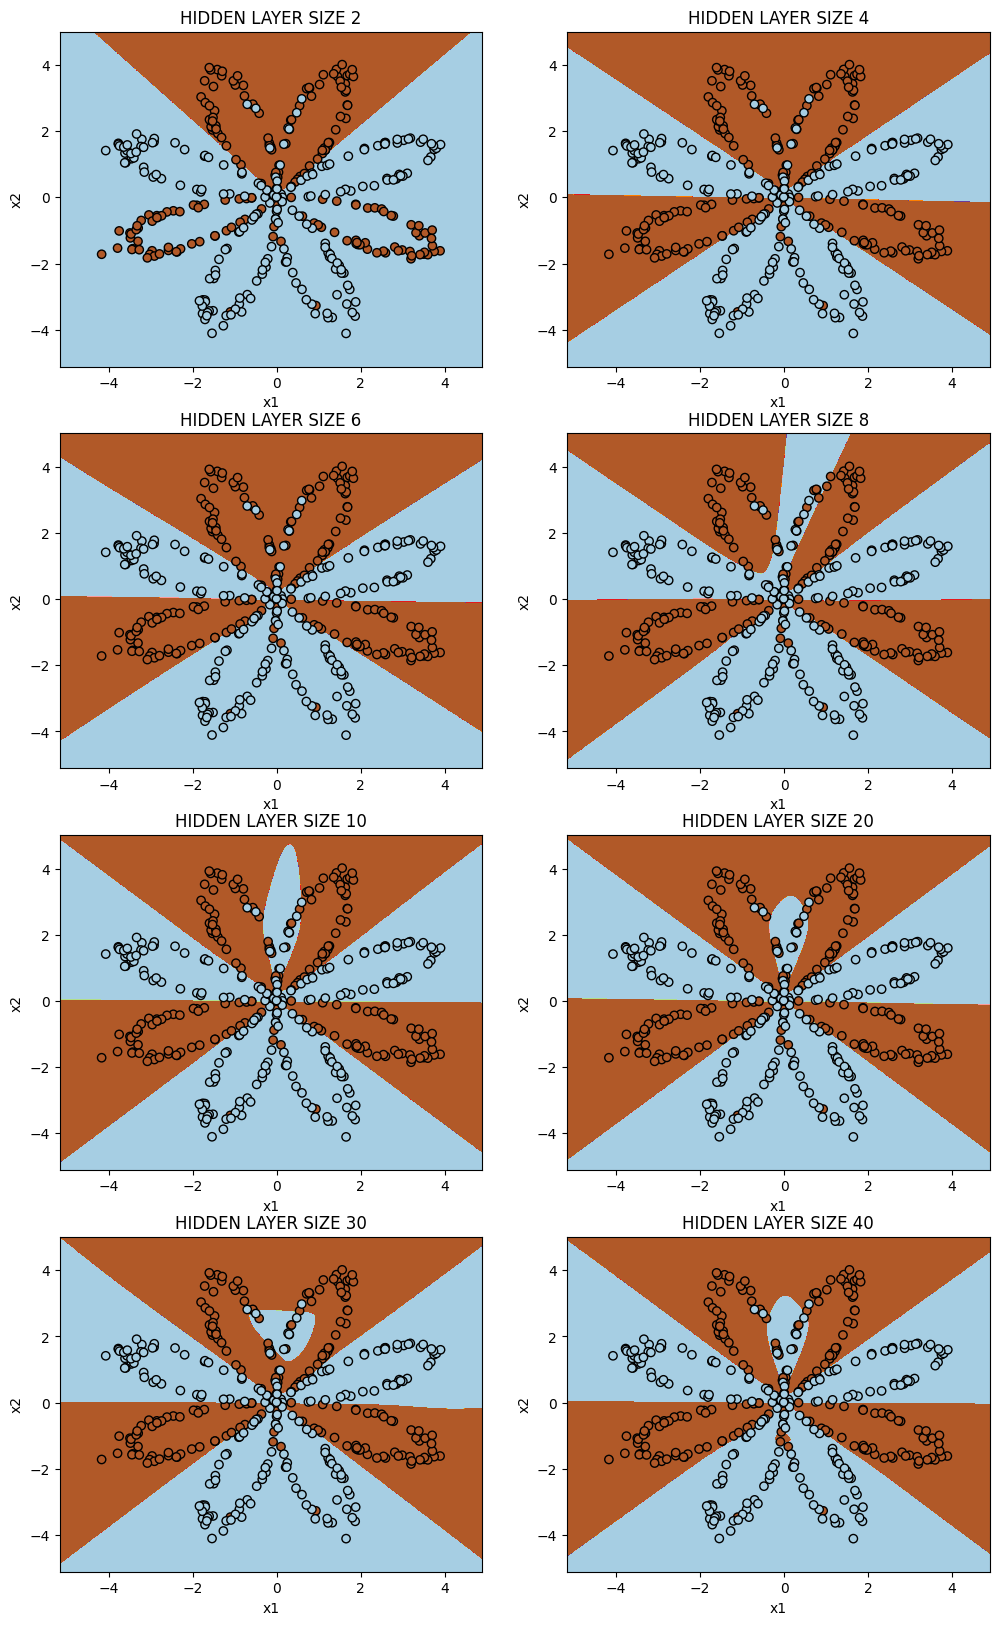

In [164]:
hidden_units_test = np.append(np.arange(2, 12, 2), np.arange(20, 50, 10))

n_cols = 2
n_rows = int(hidden_units_test.size/2)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 20))

for ix, n_h in enumerate(hidden_units_test):
    title = f'HIDDEN LAYER SIZE {n_h}'
    parameters = neural_network(X, Y, n_h, 5000)

    row = int(np.floor(ix/2)) 
    col = ix % 2
    plt.sca(axes[row,col])
    plt.title(title)
    plot_decision_boundary(preditc_func, X, Y)
    
    predictions = predict(parameters, X)

    true_positives = np.sum(np.logical_and(Y, predictions))
    
    true_negatives = np.sum(np.logical_and(
        np.logical_not(Y),
        np.logical_not(predictions)
    ))
    acc = (true_positives + true_negatives) / Y.size
    print('Accuracy for {} hidden units -> {:2.2%}'.format(n_h,acc))


The results show that we must be careful when selecting the size of our neural network. More does not mean better most of the times. In this case, higher units start to overfit the data. We can observe these signs of overfitting on the localised patches where both petals mix.

Overall, this tutorial is meant to be a quick introduction to explain how neural networks work from the ground up. Deep learning is a complex topic with multiple hyperparameters and caveats that will depend on the type of problem. However, all neural networks work under the same underlying principle.

The neural network that we created here, can be used to solve other kinds of problems. You can continue the exploration of its performance as a binary classifier with the following dataset.

In [ ]:
from sklearn.datasets import make_moons

X, Y = make_moons(n_samples=500,
                  noise=0.2,
                  random_state=101)
X = X.T
Y = Y.T
Y = Y.reshape((1,Y.shape[0]))

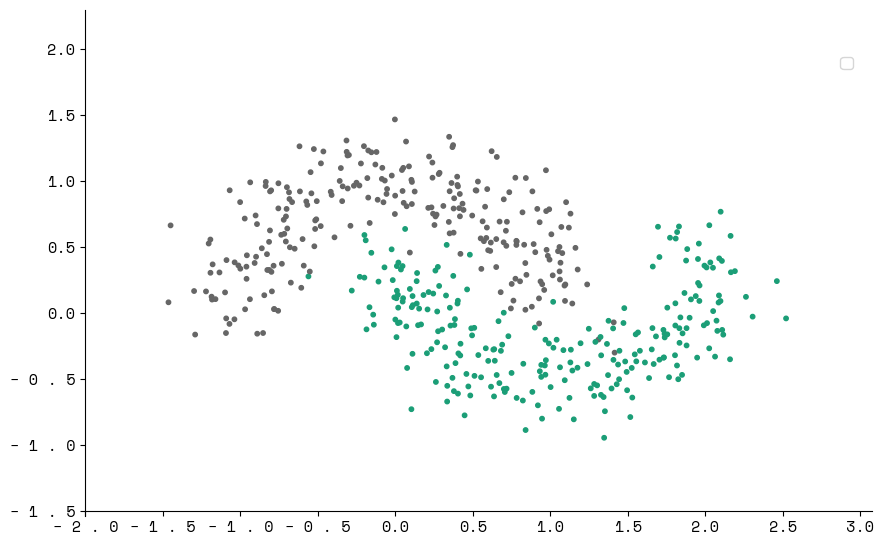

In [179]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(X[0,:],X[1,:], c=Y,s=10,cmap=plt.cm.Dark2_r,)
hf.make_fig_pretty(ax)

In [180]:
parameters = neural_network(X, Y,
                            n_hidden_units=8,
                            n_iterations=10000,
                            print_loss=True)

TRAINING:   0%|          | 0/10000 [00:00<?, ?it/s]

ITERATION 0:
 > LOSS:0.6930355010740098
ITERATION 1000:
 > LOSS:0.230754939598794
ITERATION 2000:
 > LOSS:0.061802856071525546
ITERATION 3000:
 > LOSS:0.05903409950912223
ITERATION 4000:
 > LOSS:0.05696777953240464
ITERATION 5000:
 > LOSS:0.05563659570421106
ITERATION 6000:
 > LOSS:0.05420934057317717
ITERATION 7000:
 > LOSS:0.052834434417038896
ITERATION 8000:
 > LOSS:0.051813239114917295
ITERATION 9000:
 > LOSS:0.050970965898429796


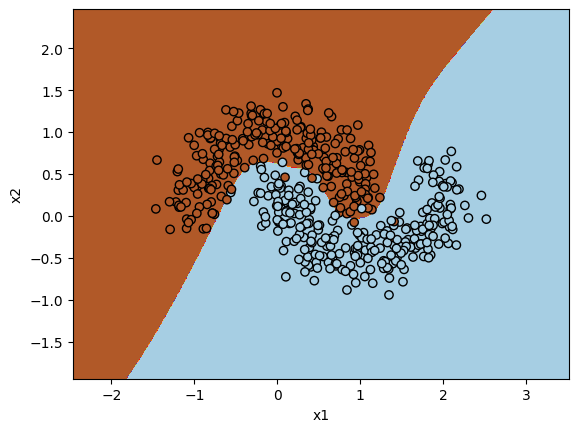

In [185]:
preditc_func = lambda x: predict(parameters, x.T,0.3)

plot_decision_boundary(preditc_func, X, Y)